# **Final Experiments about Classic ML**

**Содержимое ноутбука:**

* Этот ноутбук содержит окончательные эксперименты по нелинейным моделям классическго машинного обучения
* Итоговый пайплайн в другом месте


**Мотивация:**
* Закрыть чекпоинт, проведя эксперименты с нелинейными моделями классическго ML
* Свести эксперименты с коллегами более однозначно
* Провести новые эксперименты по новым алгоритмам, которые не были проведены раньше


**В прошлых чекпоинтах** мы показали показали, что
* Снижение размерности посредством **Спектрального разложения(SVD)** - наилучший способ предподготовки данных, при несложных моделях. Сложилось стойкое ощущение, что другие способы предобработки выдают "слишком много информации", и обучающая способность моделей не может справиться с "обилием" информации.
* Можно построить эффективные MVP только при помощи **линейных моделей**. Да, линейных.
* Нелинейные модели классического ml, выдают лучшее качество, чем линейные.



**Выборки**

Мы с коллегами, пользуясь интуицией, по-разному брали выборки для обучения.
* Первый вариант: брать `репрезентативные выборки`
* Второй вариант: брыть `одинаковые доли классов`

Текущие размышления:
* Оказалось, что **нет универсального ответа. Решение подбирается под задачу**.
* Оба варианта адекватны и имеют свои преимущества.
* Есть ещё опции. Они все отражают одну из двух идей:
    * надо естесвенным образом брать данные репрезентативно
    * надо искусственно выравнивать дисбаланс классов


**Давайте проводить эксперименты**

In [1]:
# !pip install gdown -q

In [2]:
DATA_FOLDER = "data/"

In [3]:
# import gdown

# url = 'https://drive.google.com/uc?id=1MOjORo11C6A2FbXHkWxSbL-iB237Y_Zf'
# save_name = DATA_FOLDER + 'data_DEC24_SVD_128_5000.csv'
# gdown.download(url, save_name, quiet=False)

# url = 'https://drive.google.com/uc?id=18nNEnray3VFNhnySeRaJ6fSmOAiQ3Efp'
# save_name = DATA_FOLDER + 'data_FEB25_SVD_eq_sample_128_5000.csv'
# gdown.download(url, save_name, quiet=False)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

np.random.seed(691)
random_state = 326

In [5]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

from typing import List

### Common Functions

In [6]:
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from typing import Tuple

def get_metrics(y_pred, y_true, rounding=8, verbouse=True, returns=False) -> Tuple:
    """Print/Return all metrics by predictions and true values""" 

    if returns == True:
        verbouse = False

    acc = np.round(balanced_accuracy_score(y_pred, y_true), rounding)
    f1 = np.round(f1_score(y_pred, y_true, average="weighted"), rounding)
    
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
    y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2])

    # Расчет ROC-AUC для многоклассовой задачи
    auc_score = roc_auc_score(y_true_binarized, y_pred_binarized,
                            multi_class='ovr', average=None)

    roc_auc_metric = y.value_counts(sort=False, normalize=True) @ auc_score[::-1]
    roc_auc_metric = np.round(roc_auc_metric, rounding)
    gini = 2 * roc_auc_metric - 1
    gini = np.round(gini, rounding)

    if verbouse:
        print(f"Balanced accuracy: {acc}")
        print(f"F1-score: {f1}")
        print(f"roc_auc_score: {roc_auc_metric}")
        print(f"gini_score:{gini}")

    if returns:
        return acc, f1, roc_auc_metric, gini
    

In [7]:
def plot_confusion_matrixes(model1, model2, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    LABELS = ["Pneumonia", "Other", "Normal"]
    CMAP = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

    ax[0].set_title("SVM rbf kernel")
    ax[1].set_title("Random Forest")

    disp_1 = ConfusionMatrixDisplay.from_estimator(model1, X_test, y_test, display_labels=LABELS, cmap=CMAP, normalize="true", ax=ax[0])
    disp_1.im_.set_clim(0, 1)
    disp_2 = ConfusionMatrixDisplay.from_estimator(model2, X_test, y_test, display_labels=LABELS, cmap=CMAP, normalize="true", ax=ax[1]);
    disp_2.im_.set_clim(0, 1)

### Set Save Results

In [8]:
# всегда берём 20% в тест
# 5001 - это тоже 5000
cols = ["model_name", "params", "sample_size", "sample_method", "balanced_accuracy", "f1-score", "roc_auc", "gini"]
exp_logs = pd.DataFrame(columns=cols)

SAMPLE_SIZE = 5000

In [9]:
def add_new_exp(log_storage: pd.DataFrame, new_row: List):
    """Add new row to experiments loggs from list"""
    cols = [
        "model_name", "params", "sample_size", "sample_method", 
        "balanced_accuracy", "f1-score", "roc_auc", "gini"
    ]

    new_exp = pd.DataFrame(new_row).T
    new_exp.columns=cols
    
    log_storage = pd.concat([log_storage, new_exp], ignore_index=True)
    return log_storage

## Подход репрезентативной выборки

In [10]:
df_images = pd.read_csv(DATA_FOLDER + "data_DEC24_SVD_128_5000.csv")

In [11]:
X, y = df_images.drop(columns="class"), df_images["class"]
SAMPLE_METHOD = "representative"

We have 3 classes:


|Label|Text Label|Desc|Has Bounding Box|
|:-|:-|:-|:-|
|0|Lung Opacity|Есть затемнение в лёгких, есть bounding box|Yes|
|1|No Lung Opacity / Not Normal|Нет затемнения в лёгких, нет bounding box, но есть патология|No|
|2|Normal|Здоровые лёгкие|No|

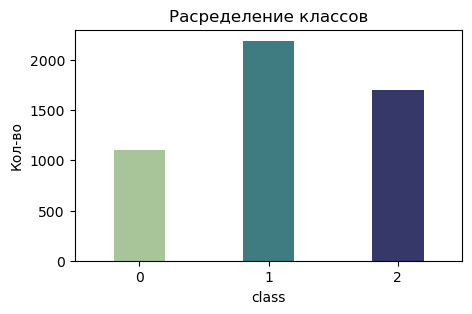

In [12]:
plt.figure(figsize = (5, 3))
sns.countplot(x=y, hue=y, legend=False, palette='crest', width=0.4)
plt.title("Расределение классов")
plt.ylabel("Кол-во");

In [13]:
y.value_counts(sort=False, normalize=True)

class
2    0.3408
1    0.4382
0    0.2210
Name: proportion, dtype: float64

### Models
Наилучшее качество среди классческих **испробованных** моделей покажет `SVC(kernel="rbf")` или `RandomForestClassifier`

Note: kernel="rbf" - это в данном контексте не гиперпараметр

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [16]:
NonLinearSVC = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(kernel = 'rbf', random_state=random_state))
])

NonLinearSVC.fit(X_train, y_train)

y_pred_SVC = NonLinearSVC.predict(X_test)

In [17]:
new_row = ["NonLinearSVC", "kernel = 'rbf'", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_SVC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [18]:
rfc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier(random_state=random_state))
])

rfc.fit(X_train, y_train)

y_pred_RFC = rfc.predict(X_test)

In [19]:
new_row = ["Random Forest", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_RFC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

### Compare models

In [20]:
exp_logs

,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651


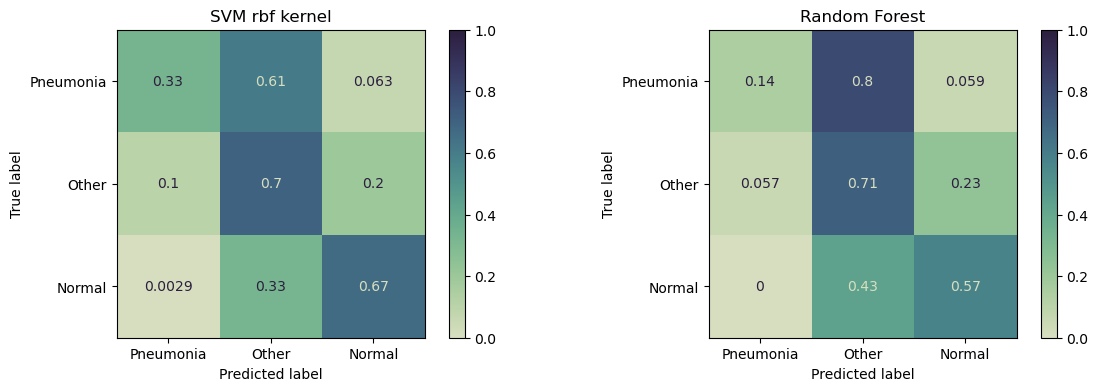

In [21]:
plot_confusion_matrixes(NonLinearSVC, rfc, X_test, y_test)

Как интерпретировать 1 ячейку: **33% наблюдений с пневмонией был отнесён к классу пневмония**

#### Прикладные выводы

Как интерпретировать матрицу ошибок:
* по строкам в сумме получается 1.
* Правильная работа модели означает более яркую диагональ
* Обе модели плохо идентифицирует наличие пневмонии

#### Новые концептуальные выводы
* Без подбора параметров SVM('rbf') справляется лучше, чем случайный лес.


#### Возникшие гипотезы
* Если подбирать параметры в случайном лесу, может станет лучше, качество будет выше метода опорных векторов. В прошлых чекпоинтах подбирать параметры для опроных мекторов было относительно бесполезно

## **Модели с подбором параметров**

Репрезентативная выборка + Подбор параметров

`[TO DO]`

`Скорее всего получится, что прирост не большой`

`Скорее всего получится, что RF будет немного лучше`

`ядро rbf гарантированно для SVM лучше подходит, уже проверяли`

[] подумай какаие параметры можно взять

[] параметры к двум моделям

[] сравнить 2 лучшие модели

In [ ]:
df_images = pd.read_csv(DATA_FOLDER + "data_DEC24_SVD_128_5000.csv")

X, y = df_images.drop(columns="class"), df_images["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [13]:
# можно сделать, например, как-то так

In [ ]:
NonLinearSVC = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(kernel = 'rbf', random_state=random_state))
])

param_grid = {
    'clf__kernel' : ['rbf'],  # да, 1 вариант
    'clf__C': [0.5, 1, 2, 5],
    'clf__tol': [1e-3, 1e-2],
}

grid_search = GridSearchCV(NonLinearSVC, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
model = grid_search.best_estimator_


y_pred_SVC = model.predict(X_test)

# ["model_name", "params", "sample_size", "sample_method", "balanced_accuracy", "f1-score", "roc_auc", "gini"] -- logging cols
get_metrics(y_pred_SVC, y_test, returns=True)

{'clf__C': 1, 'clf__kernel': 'rbf', 'clf__tol': 0.001}


(np.float64(0.62188448),
 np.float64(0.61835002),
 np.float64(0.67660542),
 np.float64(0.35321084))

In [ ]:
# доставать параметры ещё можно как-то так
# NonLinearSVC.get_params(deep=True)

In [ ]:
plot_confusion_matrixes(best_model_1, best_model_2, X_test, y_test)

### Выводы


....

# Равномерная по классам выборка
Равная выборка + Без подбора параметров

In [22]:
SAMPLE_METHOD = "equal"

df_images = pd.read_csv(DATA_FOLDER + "data_FEB25_SVD_eq_sample_128_5000.csv")
print(f"Размер выборки: {df_images.shape[0]}")

X, y = df_images.drop(columns="class"), df_images["class"]

Размер выборки: 5001


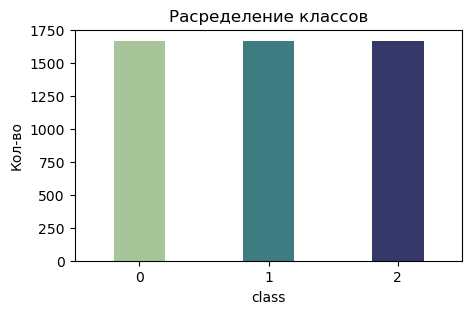

In [23]:
plt.figure(figsize = (5, 3))
sns.countplot(x=y, hue=y, legend=False, palette='crest', width=0.4,)
plt.title("Расределение классов")
plt.ylabel("Кол-во");

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

## Models & Compare Models

In [25]:
NonLinearSVC = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(kernel = 'rbf', random_state=random_state))
])

NonLinearSVC.fit(X_train, y_train)

y_pred_SVC = NonLinearSVC.predict(X_test)

In [26]:
new_row = ["NonLinearSVC", "kernel = 'rbf'", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_SVC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [27]:
rfc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier(random_state=random_state))
])

rfc.fit(X_train, y_train)

y_pred_RFC = rfc.predict(X_test)

In [28]:
new_row = ["Random Forest", "", SAMPLE_SIZE, SAMPLE_METHOD, *get_metrics(y_pred_RFC, y_test, returns=True)]
exp_logs = add_new_exp(exp_logs, new_row)

In [29]:
print("Модели без подбора параметров:")
exp_logs[(exp_logs.params == "") | (exp_logs.params == "kernel = 'rbf'")]

Модели без подбора параметров:


,model_name,params,sample_size,sample_method,balanced_accuracy,f1-score,roc_auc,gini
0,NonLinearSVC,kernel = 'rbf',5000,representative,0.621884,0.61835,0.676605,0.353211
1,Random Forest,,5000,representative,0.561821,0.567647,0.610826,0.221651
2,NonLinearSVC,kernel = 'rbf',5000,equal,0.584179,0.593288,0.692128,0.384255
3,Random Forest,,5000,equal,0.548633,0.576161,0.6734,0.346799


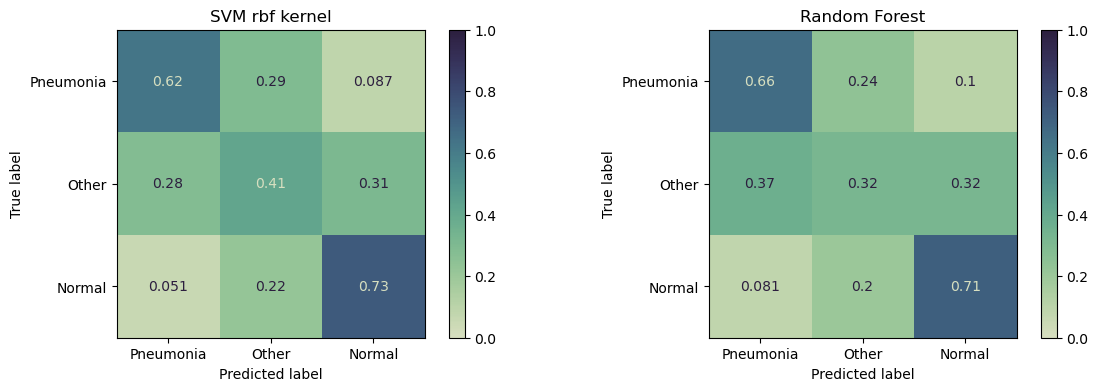

In [30]:
plot_confusion_matrixes(NonLinearSVC, rfc, X_test, y_test)

#### Прикладные выводы
* Метод опорных векторов справился немного лучше, чем случайный лес без подбора параметров
* При равной выборке модели лучше определяют пневмонию, потому что в прошлый раз она была недопредставлена.


#### Новые концептуальные выводы
* В нашем случае брать равную выборку `оказалось скорее удачным решением`. В пропорциональной выборке было моделям сложнее всего определять пневмонию/пристуствие bbox-ов
* Зато такие модели плохо определяют наличие других патологий.

#### Возникшие гипотезы
* Было показвно, что модели могут иметь проблемы с определением пневмонии и других заболеваний. А случаи нормы определяются легко. **Возможно, стоит недопредставлять нормальные случаи, если мы обучаемся на выборке.**

## Ещё эксперименты по подбору параметров
Равная выборка + Подбор параметров

`[TO DO]`

`Скорее всего получится, что смысла особо подбирать параметры нет`

Сделать тоже самое, но с другой выборкой

## Эксперименты с новыми алгоритмами

Про что рассказали на ML, то попробуем. Ансамбли.